In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

import air_traffic.temporal as tp

In [6]:
datadir = "../data/results"
savedir = ""

df = pd.read_csv("../data/results/stat_fixed_distance_145-165.csv")

In [14]:
# Get day of week; Monday is 0, Sunday is 6
# HKT is UTC+8, so add 8*3600 seconds
dow = pd.to_datetime(df["t_i"] + 8*3600, unit="s").dt.day_of_week.to_numpy()

# Get hour in day in HKT
hour = ((df["t_i"].to_numpy() + 8*3600) % 86400) / 3600

# Transit time and cluster label
delta_t = df["delta_t_sec"].to_numpy() / 60  # in minutes
cluster = df["cluster"].to_numpy()

# Time windows for computing average transit time
bins = np.arange(0, 24.1, 0.25)

## 1 - Grouping in Time

In notebook 1 we did a spatial clustering of trajectories, we can also do a "temporal clustering" by grouping the flights according to their arrivial day of the week and time of the day. It is natural to expect the transit time would be very different during Monday morning vs. Saturday midnight.

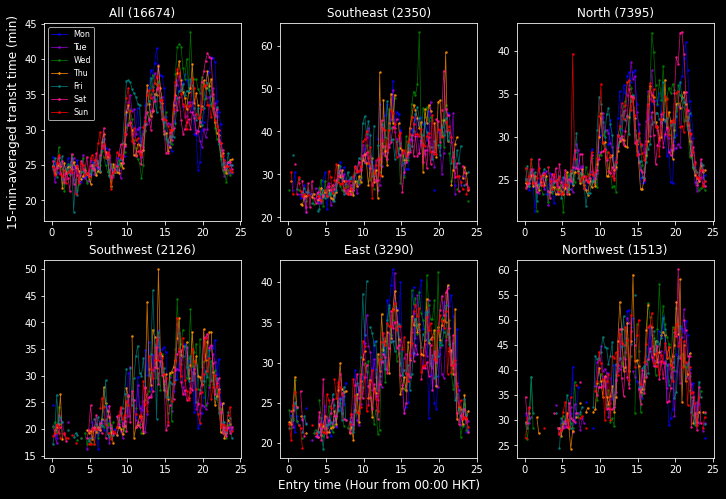

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

c_names = ["Southeast", "North", "Southwest", "East", "Northwest"]
dow_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_colors = ["blue", "darkviolet", "green", "darkorange", "teal",
              "deeppink", "red"]

for ij in range(6):
    ax = axs[ij // 3, ij % 3]

    # First figure contain all clusters
    if ij == 0:
        dow_ = dow
        hour_ = hour
        delta_t_ = delta_t

        ax.set_title(f"All ({len(delta_t_)})", fontsize=12)

    # Then do one cluster per subplot
    else:
        # Extract rows that are in the right cluster
        index = np.where(cluster == ij - 1)
        dow_ = dow[index]
        hour_ = hour[index]
        delta_t_ = delta_t[index]

        ax.set_title(f"{c_names[ij-1]} ({len(delta_t_)})", fontsize=12)

    # Plot each day of week seperately
    for k in range(7):
        # Extract rows in the right day of week
        index = np.where(dow_ == k)
        hour_plot = hour_[index]
        delta_t_plot = delta_t_[index]

        mean, edges, _ = binned_statistic(hour_plot, delta_t_plot, 
                                          statistic="mean", bins=bins)
        centers = (edges[:-1] + edges[1:]) / 2
        
        ax.plot(centers, mean, marker="o", markersize=1.5, lw=0.75,
                color=dow_colors[k], alpha=0.8)


    # Curve labels and y-axis label on top left
    if ij == 0:
        for k in range(7):
            ax.plot([], [], marker="o", markersize=1.5, lw=0.75,
                    color=dow_colors[k], label=dow_names[k])
            
        ax.legend(fontsize=8)
        ax.set_ylabel("15-min-averaged transit time (min)", fontsize=12)

    
    # x-axis label on bottom center
    if ij == 4:
        ax.set_xlabel("Entry time (Hour from 00:00 HKT)", fontsize=12)


plt.show()

*Notes:*
1. *Some of the curves are broken because using only one month of data is not quite enough to provide the temporal resolution we asked for. But the pattern is the same if we pour in more data.*
2. *There is an unusual peak in the North cluster in early Sunday morning. This is just random fluctuation that will be averaged out if we put in more data.*


One interesting feature is average transit time consistently have a wave-like pattern in all directional cluster and on all days of the week. These wave-like patterns can be better extracted via a Fourier transform. The Fourier spectral would have a dominant peak at period of 24 hours, representing the daily trend. But apart from that, there are also several weaker yet significant peaks. Understanding the origin of these patterns may be useful for prediction.

In [21]:
# Fetch the transit time moving average time series

# Get the timestamp again
time = ((df["t_i"].to_numpy() + 8*3600))

delta_avg, t_axis = tp.moving_avg(delta_t, time, dt=15*60, start_hour=-1)
t_axis -= t_axis[0]  # Zero the time axis


# delta_avg will have nan when there are no arrivial data
# So replace nan by zeros
delta_avg[np.isnan(delta_avg)] = 0


spectrum = np.abs(np.fft.rfft(delta_avg - np.average(delta_avg)))
spectrum /= np.max(spectrum)

freq = np.fft.rfftfreq(len(delta_avg), d=15*60) * 3600
period = 1 / freq

/tmp/ipykernel_142770/2896986701.py:19: RuntimeWarning: divide by zero encountered in true_divide
  period = 1 / freq


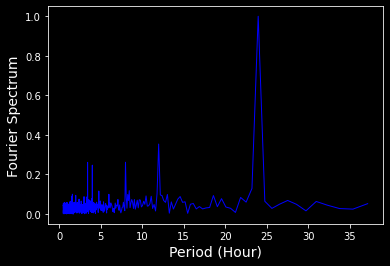

In [24]:
fig, ax = plt.subplots()

# Zoom in to the part of the spectrum of interest
ax.plot(period[20:], spectrum[20:], color="blue", lw=1)

ax.set_xlabel("Period (Hour)", fontsize=14)
ax.set_ylabel("Fourier Spectrum", fontsize=14)

plt.show()

Another interesting feature: If we plot also the number of flights entering the 145-165 km ring in the past 15 minutes, we can see a clear **lead-lag** pattern, where the entry count strongly leads the average transit time. This will be another useful feature for making predictions.

In [25]:
# Compute overall (all cluster together) mean transit time and entry count
mean_all, edges, _ = binned_statistic(hour, delta_t, statistic="mean",
                                      bins=bins)
count, _, _ = binned_statistic(hour, delta_t, statistic="count",
                               bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

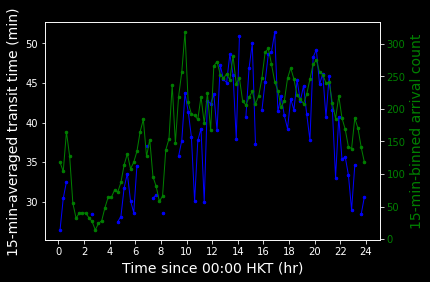

In [30]:
fig, ax = plt.subplots()
ax.plot(centers, mean, marker="o", markersize=2.5, lw=1.0,
        color="blue", alpha=1.0)

axt = ax.twinx()
axt.plot(centers, count, marker="o", markersize=2.5, lw=1.0,
         color="green", alpha=1.0)

ax.set_ylabel("15-min-averaged transit time (min)", fontsize=14)
axt.set_ylabel("15-min-binned entry count", fontsize=14, color="green")
axt.tick_params(axis="y", labelcolor="green")
ax.set_xlabel("Time since 00:00 HKT (hr)", fontsize=14)

ax.set_xticks(np.arange(0, 25, 2))

plt.show()

## 2 - Autocorrelation Structure

One more thing we can study is the autocorrelation function of the arrival rate time series. This could tell us something about the historical dependency of the arrival statistics. The bright triangle of the left side shows strong correlation of traffic around noon time, and the small bright spots in the upper triagnular region indicates correlation of traffic in sucessive days.

*Slight caveat here: The way I calculate the autocorrelation function here implicitly assumed the arrivial rate is dominated by the daily trend and is otherwise stationary, which is obviously not the case. But the resulting autocorrelation stucture is not signifcant enough to worry about this assumption anyway.*

In [28]:
# Compute arrivial rate
arrivial_times = df["t_f"].to_numpy()
dt = 60 * 15    # 15 minute time window

rate, t_axis = tp.arrivial_rate(arrivial_times, dt, start_hour=16, start_by="cut")
rate = tp.nullify_day(rate, dt)

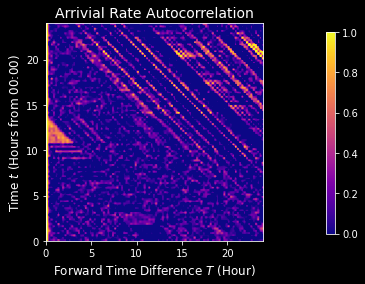

In [29]:
# Assume the arrivial rate follows a purely daily trend
a_matrix = tp.autocorr_period(rate, dt, period=86400)

fig, ax = plt.subplots()
t_max = len(a_matrix[0]) * dt / 3600


im = ax.imshow(a_matrix, cmap="plasma", extent=(0, t_max, 0, t_max),
               origin="lower", vmin=0, vmax=1)

ax.set_ylabel("Time $t$ (Hours from 00:00)", fontsize=12)
ax.set_xlabel("Forward Time Difference $T$ (Hour)", fontsize=12)
ax.set_title(f"Arrivial Rate Autocorrelation", fontsize=14)

cax = plt.axes([0.91, 0.15, 0.02, 0.7])
plt.colorbar(im, cax)

plt.show()